In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import seaborn as sns
#import ggplot

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import re
import time 

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle # to shuffle the data 

%matplotlib inline
plt.style.use('seaborn-whitegrid')

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import KFold, StratifiedKFold

#### There are 25 variables:

ID: ID of each client
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
SEX: Gender (1=male, 2=female)
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
MARRIAGE: Marital status (1=married, 2=single, 3=others)
AGE: Age in years
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
PAY_2: Repayment status in August, 2005 (scale same as above)
PAY_3: Repayment status in July, 2005 (scale same as above)
PAY_4: Repayment status in June, 2005 (scale same as above)
PAY_5: Repayment status in May, 2005 (scale same as above)
PAY_6: Repayment status in April, 2005 (scale same as above)
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
default.payment.next.month: Default payment (1=yes, 0=no)

In [3]:
data = pd.read_csv("UCI_Credit_Card.csv")

In [4]:
lis = [ 'LIMIT_BAL','AGE','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_pay']

In [4]:
data = data.rename(columns={'default.payment.next.month': 'default_pay', 'PAY_0': 'PAY_1'})

In [6]:
data.head()
# default_pay (1=yes, 0=No)
# gender (1=male, 2=female)
# MARRIAGE (1=married, 2=single, 3=others)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_pay
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
data.shape

(30000, 25)

EDUCATION has categories 5, 6 and 0 that are unlabelled.
MARRIAGE has a label 0 that is undocumented

In [8]:
data['EDUCATION'].replace(0, 4,inplace=True)
data['EDUCATION'].replace(5, 4,inplace=True)
data['EDUCATION'].replace(6, 4,inplace=True)

In [9]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

for payment we are now using (0=pay duly, 1 = delay for one month, 2 = delay for two months etc.)

In [10]:
data['PAY_1'].replace(-1, 0,inplace=True)
data['PAY_1'].replace(-2, 0,inplace=True)

In [11]:
data['PAY_2'].replace(-1, 0,inplace=True)
data['PAY_2'].replace(-2, 0,inplace=True)

In [12]:
data['PAY_3'].replace(-1, 0,inplace=True)
data['PAY_3'].replace(-2, 0,inplace=True)

In [13]:
data['PAY_4'].replace(-1, 0,inplace=True)
data['PAY_4'].replace(-2, 0,inplace=True)

In [14]:
data['PAY_5'].replace(-1, 0,inplace=True)
data['PAY_5'].replace(-2, 0,inplace=True)

In [15]:
data['PAY_6'].replace(-1, 0,inplace=True)
data['PAY_6'].replace(-2, 0,inplace=True)

In [16]:
# changing '0' to '3' for marriage (1=married, 2=single, 3=others)
data['MARRIAGE'].replace(0, 3, inplace=True)

In [17]:
data.groupby(['SEX', 'default_pay']).size()

SEX  default_pay
1    0               9015
     1               2873
2    0              14349
     1               3763
dtype: int64

### replace all negative values with nan in dataset 

In [18]:
data.loc[(data['BILL_AMT1'] < 0), 'BILL_AMT1']=np.nan
data.loc[(data['BILL_AMT2'] < 0), 'BILL_AMT2']=np.nan
data.loc[(data['BILL_AMT3'] < 0), 'BILL_AMT3']=np.nan
data.loc[(data['BILL_AMT4'] < 0), 'BILL_AMT4']=np.nan
data.loc[(data['BILL_AMT5'] < 0), 'BILL_AMT5']=np.nan
data.loc[(data['BILL_AMT6'] < 0), 'BILL_AMT6']=np.nan

In [19]:
data.columns.get_loc("BILL_AMT6")

17

In [20]:
data.iloc[:,12:18 ].isnull().sum()

BILL_AMT1    590
BILL_AMT2    669
BILL_AMT3    655
BILL_AMT4    675
BILL_AMT5    655
BILL_AMT6    688
dtype: int64

In [21]:
# To view all columns
from IPython.display import display
pd.options.display.max_columns = None
display(data.tail(10))

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_pay
29990,29991,140000.0,1,2,1,41,0,0,0,0,0,0,138325.0,137142.0,139110.0,138262.0,49675.0,46121.0,6000.0,7000.0,4228.0,1505.0,2000.0,2000.0,0
29991,29992,210000.0,1,2,1,34,3,2,2,2,2,2,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,1
29992,29993,10000.0,1,3,1,43,0,0,0,0,0,0,8802.0,10400.0,0.0,0.0,0.0,0.0,2000.0,0.0,0.0,0.0,0.0,0.0,0
29993,29994,100000.0,1,1,2,38,0,0,0,0,0,0,3042.0,1427.0,102996.0,70626.0,69473.0,55004.0,2000.0,111784.0,4000.0,3000.0,2000.0,2000.0,0
29994,29995,80000.0,1,2,2,34,2,2,2,2,2,2,72557.0,77708.0,79384.0,77519.0,82607.0,81158.0,7000.0,3500.0,0.0,7000.0,0.0,4000.0,1
29995,29996,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,0,0,0,0,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,0,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,0,0,0,0,0,NaN,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1
29999,30000,50000.0,1,2,1,46,0,0,0,0,0,0,47929.0,48905.0,49764.0,36535.0,32428.0,15313.0,2078.0,1800.0,1430.0,1000.0,1000.0,1000.0,1


### Replacing the nan values using imputation method
There are clients that paid more then they were asked to, had even a negative bill in Sept., and still have a month of delay, and even defaulted the next month, so i am going to convert all the negative values into nan's and will replace them with mean.

In [22]:
data['BILL_AMT1'].loc[5]

64400.0

In [28]:
data['BILL_AMT1'].loc[5] = np.nan

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


now we will fill the 5th location with mean/median and use the method which gives the closest result.

In [29]:
data['BILL_AMT1'].mean()

52273.68686456527

In [30]:
data['BILL_AMT1'].median()

23790.0

As mean is closer to actual result so using the mean to fill the nan values.

In [23]:
data['BILL_AMT1'] = data['BILL_AMT1'].fillna(data['BILL_AMT1'].mean())
data['BILL_AMT2'] = data['BILL_AMT2'].fillna(data['BILL_AMT2'].mean())
data['BILL_AMT3'] = data['BILL_AMT3'].fillna(data['BILL_AMT3'].mean())
data['BILL_AMT4'] = data['BILL_AMT4'].fillna(data['BILL_AMT4'].mean())
data['BILL_AMT5'] = data['BILL_AMT5'].fillna(data['BILL_AMT5'].mean())
data['BILL_AMT6'] = data['BILL_AMT6'].fillna(data['BILL_AMT6'].mean())

In [24]:
data.iloc[:,12:18 ].isna().sum()

BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
dtype: int64

### Replacing the missing values with KNN imputation

In [46]:
#from tqdm import tqdm

In [30]:
# #using for loop to replace the negative values with nan
# for i in tqdm(range (12, 18)):
#     data2.iloc[:,i] = data2.iloc[:,i].replace((data2.iloc[:,i] < 0), np.nan)

In [23]:
data2 = data

In [24]:
data2.loc[(data2['BILL_AMT1'] < 0), 'BILL_AMT1']=np.nan
data2.loc[(data2['BILL_AMT2'] < 0), 'BILL_AMT2']=np.nan
data2.loc[(data2['BILL_AMT3'] < 0), 'BILL_AMT3']=np.nan
data2.loc[(data2['BILL_AMT4'] < 0), 'BILL_AMT4']=np.nan
data2.loc[(data2['BILL_AMT5'] < 0), 'BILL_AMT5']=np.nan
data2.loc[(data2['BILL_AMT6'] < 0), 'BILL_AMT6']=np.nan

In [27]:
data2.iloc[:,12:18].isna().sum()

BILL_AMT1    590
BILL_AMT2    669
BILL_AMT3    655
BILL_AMT4    675
BILL_AMT5    655
BILL_AMT6    688
dtype: int64

In [26]:
data2.columns[18]

'PAY_AMT1'

Replacing the missing values with KNN imputation

In [13]:
from sklearn.impute import KNNImputer

In [14]:
imputer = KNNImputer(n_neighbors=2)
data2['BILL_AMT1']= imputer.fit_transform(data2[['BILL_AMT1']])
data2['BILL_AMT2']= imputer.fit_transform(data2[['BILL_AMT2']])
data2['BILL_AMT3']= imputer.fit_transform(data2[['BILL_AMT3']])
data2['BILL_AMT4']= imputer.fit_transform(data2[['BILL_AMT4']])
data2['BILL_AMT5']= imputer.fit_transform(data2[['BILL_AMT5']])
data2['BILL_AMT6']= imputer.fit_transform(data2[['BILL_AMT6']])

In [60]:
data2

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_pay
0,1,20000.0,2,2,1,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,0,0,0,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,0,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [15]:
data2.iloc[:,12:18].isna().sum()

BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
dtype: int64

In [26]:
#data2['BILL_AMT1'].isna().value_counts()

### Outlier Analysis

In [27]:
data2 = data

In [28]:
for i in lis:
    data2.loc[:,i] = data2.loc[:,i].astype('object')

CPU times: user 66.7 ms, sys: 4.25 ms, total: 70.9 ms
Wall time: 77.9 ms


{'whiskers': [<matplotlib.lines.Line2D at 0x1a1f7e0e90>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1f7f0950>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1f7e0250>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1f7e0f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1f7f78d0>],
 'means': []}

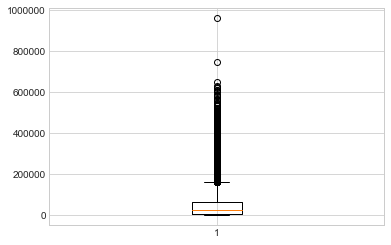

In [29]:
%%time
%matplotlib inline 
plt.boxplot(data2['BILL_AMT1'])

CPU times: user 56.1 ms, sys: 4.72 ms, total: 60.9 ms
Wall time: 63.6 ms


{'whiskers': [<matplotlib.lines.Line2D at 0x1a1f5dbc10>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1f5e0710>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1f5cef10>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1f5dbcd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1f5e8690>],
 'means': []}

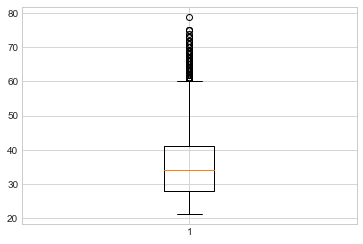

In [30]:
%%time
%matplotlib inline 
plt.boxplot(data2['AGE'])

### Replacing the outliers with nan

In [29]:
# dataset = []
# for i in lis:
#     Q1 = data2[i].quantile(0.25)
#     Q3 = data2[i].quantile(0.75)
#     IQR = Q3 - Q1
#     min = Q1 - (IQR*1.5)
#     max = Q3 + (IQR*1.5)
#     data2.loc[data2[i]<min1, ] =np.nan
#     data2.loc[data2['LIMIT_BAL']>max1, 'LIMIT_BAL'] =np.nan
# #     fil = ((data2[i] < min) & (data2[i] > max))
# #     dataset.append(fil)
# #     #data2[i][fil] = np.nan

In [31]:
values = []
for i in lis:
    Q1 = data2[i].quantile(0.25)
    Q3 = data2[i].quantile(0.75)
    IQR = Q3 - Q1
    min1 = Q1 - (IQR*1.5)
    max1 = Q3 + (IQR*1.5)
    values.append((min1, max1))
    print(i) 
    print(((data2[i] < (Q1 - 1.5 * IQR)) | (data2[i] > (Q3 + 1.5 * IQR))).sum())

LIMIT_BAL
167
AGE
272
BILL_AMT1
2430
BILL_AMT2
2426
BILL_AMT3
2504
BILL_AMT4
2670
BILL_AMT5
2766
BILL_AMT6
2727
PAY_AMT1
2745
PAY_AMT2
2714
PAY_AMT3
2598
PAY_AMT4
2994
PAY_AMT5
2945
PAY_AMT6
2958
default_pay
6636


In [32]:
values

[(-235000.0, 525000.0),
 (8.5, 60.5),
 (-89447.75, 161014.25),
 (-86009.375, 154015.625),
 (-81154.0, 144956.0),
 (-73944.0, 131576.0),
 (-69196.375, 121822.625),
 (-69219.875, 120249.125),
 (-5009.0, 11015.0),
 (-5417.5, 11250.5),
 (-5782.5, 10677.5),
 (-5279.875, 9589.125),
 (-5416.0, 9700.0),
 (-5705.625, 9823.375),
 (0.0, 0.0)]

In [27]:
data2

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_pay
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [28]:
df_outliers = pd.DataFrame(values) 

In [26]:
pd.DataFrame?

In [29]:
outlier_list = pd.DataFrame(values, columns = ['min1' , 'max1']) 

In [55]:
outlier_list.dtypes

min1    float64
max1    float64
dtype: object

In [30]:
outlier_list

,min1,max1
0,-235000.000,525000.000
1,8.500,60.500
2,-91739.625,162389.375
3,-88547.500,155538.500
4,-83581.500,146412.500
5,-75942.125,132774.875
6,-70878.250,122831.750
7,-70657.375,121111.625
8,-5009.000,11015.000
9,-5417.500,11250.500


In [57]:
# Q1 = data2['LIMIT_BAL'].quantile(0.25)
# Q3 = data2['LIMIT_BAL'].quantile(0.75)
# IQR = Q3 - Q1
# min1 = Q1 - (IQR*1.5)
# max1 = Q3 + (IQR*1.5)
# data2.loc[data2['LIMIT_BAL'] < min1,'LIMIT_BAL'] = np.nan

# # data2.replace(to_replace = data2['LIMIT_BAL']<min1, value = np.nan) 
# # data2.replace(to_replace = data2['LIMIT_BAL']>max1, value = np.nan) 

In [33]:
Q1 = data2['LIMIT_BAL'].quantile(0.25)
Q3 = data2['LIMIT_BAL'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['LIMIT_BAL']<min1, 'LIMIT_BAL'] =np.nan
data2.loc[data2['LIMIT_BAL']>max1, 'LIMIT_BAL'] =np.nan

In [34]:
Q1 = data2['AGE'].quantile(0.25)
Q3 = data2['AGE'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['AGE']<min1, 'AGE'] =np.nan
data2.loc[data2['AGE']>max1, 'AGE'] =np.nan

In [35]:
Q1 = data2['BILL_AMT1'].quantile(0.25)
Q3 = data2['BILL_AMT1'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['BILL_AMT1']<min1, 'BILL_AMT1'] =np.nan
data2.loc[data2['BILL_AMT1']>max1, 'BILL_AMT1'] =np.nan

In [36]:
Q1 = data2['BILL_AMT2'].quantile(0.25)
Q3 = data2['BILL_AMT2'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['BILL_AMT2']<min1, 'BILL_AMT2'] =np.nan
data2.loc[data2['BILL_AMT2']>max1, 'BILL_AMT2'] =np.nan

In [37]:
Q1 = data2['BILL_AMT3'].quantile(0.25)
Q3 = data2['BILL_AMT3'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['BILL_AMT3']<min1, 'BILL_AMT3'] =np.nan
data2.loc[data2['BILL_AMT3']>max1, 'BILL_AMT3'] =np.nan

In [38]:
Q1 = data2['BILL_AMT4'].quantile(0.25)
Q3 = data2['BILL_AMT4'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['BILL_AMT4']<min1, 'BILL_AMT4'] =np.nan
data2.loc[data2['BILL_AMT4']>max1, 'BILL_AMT4'] =np.nan

In [39]:
Q1 = data2['BILL_AMT5'].quantile(0.25)
Q3 = data2['BILL_AMT5'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['BILL_AMT5']<min1, 'BILL_AMT5'] =np.nan
data2.loc[data2['BILL_AMT5']>max1, 'BILL_AMT5'] =np.nan

In [40]:
Q1 = data2['BILL_AMT6'].quantile(0.25)
Q3 = data2['BILL_AMT6'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['BILL_AMT6']<min1, 'BILL_AMT6'] =np.nan
data2.loc[data2['BILL_AMT6']>max1, 'BILL_AMT6'] =np.nan

In [41]:
Q1 = data2['PAY_AMT1'].quantile(0.25)
Q3 = data2['PAY_AMT1'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['PAY_AMT1']<min1, 'PAY_AMT1'] =np.nan
data2.loc[data2['PAY_AMT1']>max1, 'PAY_AMT1'] =np.nan

In [42]:
Q1 = data2['PAY_AMT2'].quantile(0.25)
Q3 = data2['PAY_AMT2'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['PAY_AMT2']<min1, 'PAY_AMT2'] =np.nan
data2.loc[data2['PAY_AMT2']>max1, 'PAY_AMT2'] =np.nan

In [43]:
Q1 = data2['PAY_AMT3'].quantile(0.25)
Q3 = data2['PAY_AMT3'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['PAY_AMT3']<min1, 'PAY_AMT3'] =np.nan
data2.loc[data2['PAY_AMT3']>max1, 'PAY_AMT3'] =np.nan

In [44]:
Q1 = data2['PAY_AMT4'].quantile(0.25)
Q3 = data2['PAY_AMT4'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['PAY_AMT4']<min1, 'PAY_AMT4'] =np.nan
data2.loc[data2['PAY_AMT4']>max1, 'PAY_AMT4'] =np.nan

In [45]:
Q1 = data2['PAY_AMT5'].quantile(0.25)
Q3 = data2['PAY_AMT5'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['PAY_AMT5']<min1, 'PAY_AMT5'] =np.nan
data2.loc[data2['PAY_AMT5']>max1, 'PAY_AMT5'] =np.nan

In [46]:
Q1 = data2['PAY_AMT6'].quantile(0.25)
Q3 = data2['PAY_AMT6'].quantile(0.75)
IQR = Q3 - Q1
min1 = Q1 - (IQR*1.5)
max1 = Q3 + (IQR*1.5)
data2.loc[data2['PAY_AMT6']<min1, 'PAY_AMT6'] =np.nan
data2.loc[data2['PAY_AMT6']>max1, 'PAY_AMT6'] =np.nan

we didn't replce the outliers with means directly as the outliers will affect the mean. Now replacing the null values with mean.

In [47]:
data2.iloc[:,12:18 ].isna().sum()

BILL_AMT1    2430
BILL_AMT2    2426
BILL_AMT3    2504
BILL_AMT4    2670
BILL_AMT5    2766
BILL_AMT6    2727
dtype: int64

In [48]:
data2['LIMIT_BAL'] = data2['LIMIT_BAL'].fillna(data2['LIMIT_BAL'].mean())
data2['AGE'] = data2['AGE'].fillna(data2['AGE'].mean())
data2['BILL_AMT1'] = data2['BILL_AMT1'].fillna(data2['BILL_AMT1'].mean())
data2['BILL_AMT2'] = data2['BILL_AMT2'].fillna(data2['BILL_AMT2'].mean())
data2['BILL_AMT3'] = data2['BILL_AMT3'].fillna(data2['BILL_AMT3'].mean())
data2['BILL_AMT4'] = data2['BILL_AMT4'].fillna(data2['BILL_AMT4'].mean())
data2['BILL_AMT5'] = data2['BILL_AMT5'].fillna(data2['BILL_AMT5'].mean())
data2['BILL_AMT6'] = data2['BILL_AMT6'].fillna(data2['BILL_AMT6'].mean())

data2['PAY_AMT1'] = data2['PAY_AMT1'].fillna(data2['PAY_AMT1'].mean())
data2['PAY_AMT2'] = data2['PAY_AMT2'].fillna(data2['PAY_AMT2'].mean())
data2['PAY_AMT3'] = data2['PAY_AMT3'].fillna(data2['PAY_AMT3'].mean())
data2['PAY_AMT4'] = data2['PAY_AMT4'].fillna(data2['PAY_AMT4'].mean())
data2['PAY_AMT5'] = data2['PAY_AMT5'].fillna(data2['PAY_AMT5'].mean())
data2['PAY_AMT6'] = data2['PAY_AMT6'].fillna(data2['PAY_AMT6'].mean())

### Feature Selection (Correlation Analysis)

In [49]:
data2.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_pay'],
      dtype='object')

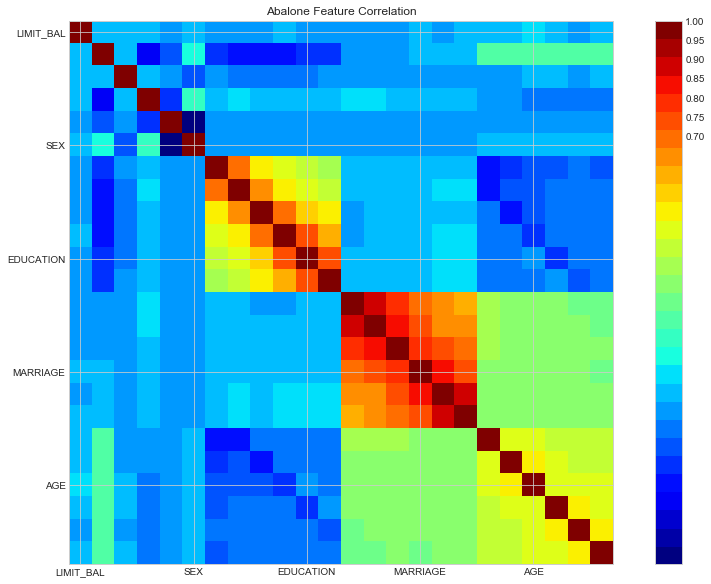

In [50]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(),interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation')
    labels=['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_pay']
    ax1.set_yticklabels(labels)
    ax1.set_xticklabels(labels)
    #ax1.set_xticklabels(labels,fontsize=10)
    #ax1.set_yticklabels(labels,fontsize=10)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.70,.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(data2)

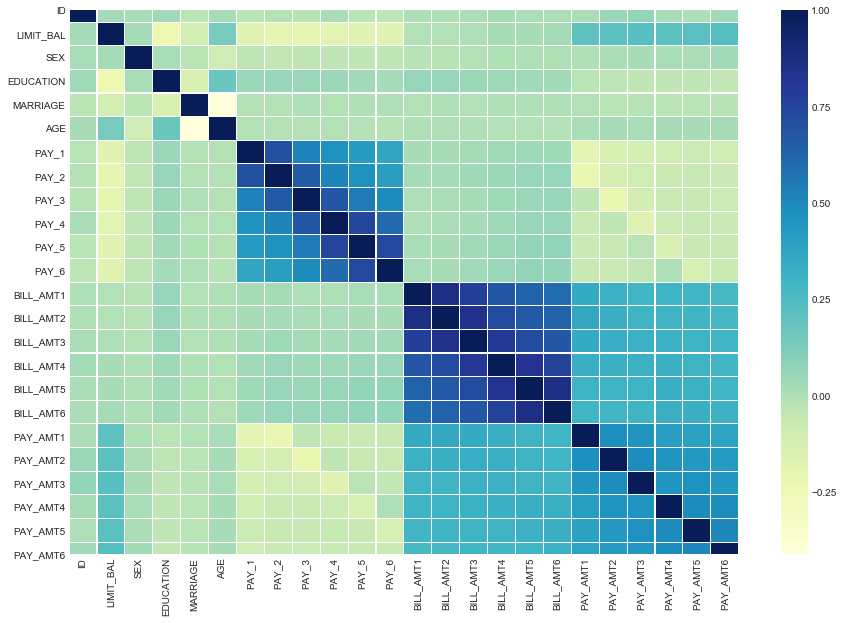

In [51]:
corrmat = data2.corr() 

f, ax = plt.subplots(figsize =(15, 10)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

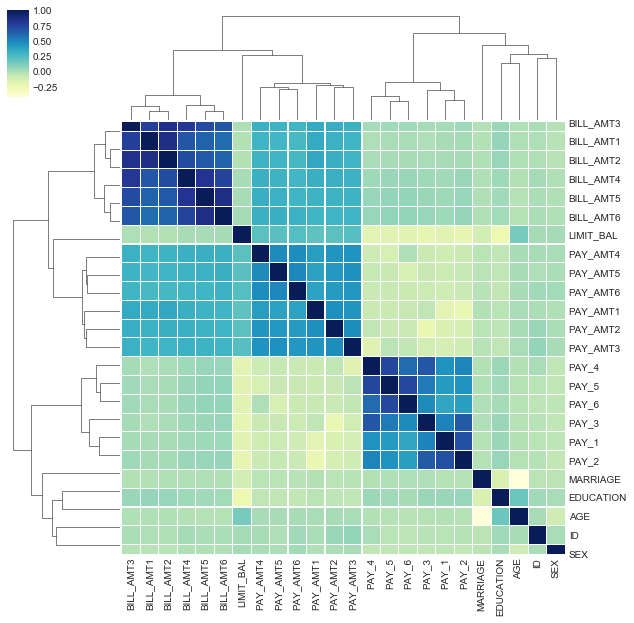

In [52]:
corrmat = data2.corr() 
  
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
  
cg 

In [53]:
def correlation(Col1, Col2):
    res = data2.groupby([Col1, Col2]).size().unstack()
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [54]:
correlation('EDUCATION', 'default_pay')
#Higher the education lower is the probability of defaulting 

default_pay,0,1,perc
EDUCATION,,,
1,8549,2036,0.192348
2,10700,3330,0.237349
3,3680,1237,0.251576
4,435,33,0.070513


In [68]:
correlation('MARRIAGE', 'default_pay')
#married people and other are most likey gonna default

default_pay,0,1,perc
MARRIAGE,,,
1,10453,3206,0.234717
2,12623,3341,0.209283
3,288,89,0.236074


In [69]:
correlation('EDUCATION', 'SEX')

SEX,1,2,perc
EDUCATION,,,
1,4354,6231,0.588663
2,5374,8656,0.616964
3,1990,2927,0.595282
4,170,298,0.636752


In [70]:
data2[data2.default_pay == 1][['BILL_AMT2', 'PAY_AMT1', 'default_pay']].sample(10)

,BILL_AMT2,PAY_AMT1,default_pay
24810,390.0,390.000000,1
25006,46868.0,0.000000,1
9892,140013.0,2739.524821,1
27823,79062.0,15.000000,1
2530,390.0,390.000000,1
17812,6571.0,0.000000,1
19091,42816.0,4600.000000,1
25312,100190.0,5000.000000,1
25652,17770.0,1558.000000,1
5075,21187.0,0.000000,1


I saw that men are most likely to default and also that married people are most likely to default. 
Thus why not combine them in a single variable given by the product of the two.
as we can see high correlation between the two categories hence we are going to combime 'SEX' and 'MARRIAGE' and make a new column

In [55]:
data2['gen_mar'] = 0
data2.loc[((data2.SEX == 1) & (data2.MARRIAGE == 1)) , 'gen_mar'] = 1 #married man
data2.loc[((data2.SEX == 1) & (data2.MARRIAGE == 2)) , 'gen_mar'] = 2 #single man
data2.loc[((data2.SEX == 1) & (data2.MARRIAGE == 3)) , 'gen_mar'] = 3 #divorced man
data2.loc[((data2.SEX == 2) & (data2.MARRIAGE == 1)) , 'gen_mar'] = 4 #married woman
data2.loc[((data2.SEX == 2) & (data2.MARRIAGE == 2)) , 'gen_mar'] = 5 #single woman
data2.loc[((data2.SEX == 2) & (data2.MARRIAGE == 3)) , 'gen_mar'] = 6 #divorced woman
correlation('gen_mar', 'default_pay')

default_pay,0,1,perc
gen_mar,,,
1,3844,1346,0.259345
2,5068,1485,0.226614
3,103,42,0.289655
4,6609,1860,0.219625
5,7555,1856,0.197216
6,185,47,0.202586


###  Deleting columns 'SEX' and 'MARRIAGE'


In [56]:
del data2['SEX']
del data2['MARRIAGE']

### Making bin for various age groups 

In [57]:
data2['Age_bin'] = pd.cut(data2.AGE, bins = 6, labels=[1,2,3,4,5,6])

In [58]:
data2.gen_mar.value_counts()

5    9411
4    8469
2    6553
1    5190
6     232
3     145
Name: gen_mar, dtype: int64

In [59]:
data2.columns

Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_pay',
       'gen_mar', 'Age_bin'],
      dtype='object')

In [60]:
data2.shape

(30000, 25)

In [61]:
cols = list(data2.columns)
cols = cols[:-3] + [cols[-2]] + [cols[-1]] +[cols[-3]]
data2 = data2[cols]

In [62]:
del data2['AGE']

In [63]:
data2.columns

Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'gen_mar', 'Age_bin',
       'default_pay'],
      dtype='object')

In [64]:
data2.shape

(30000, 24)

### Load the final dataset 

In [81]:
# # save data (without replacing -ve values + replacing outliers + feature selection) as pikel file 
# joblib.dump(data2, 'cleanedcreditcard_1.pkl')

['cleanedcreditcard_1.pkl']

In [3]:
# # Load the data(without replacing -ve values + replacing outliers + feature selection) clean data from the file 
# data2 = joblib.load('cleanedcreditcard_1.pkl')

In [65]:
# # save data (replacing -ve values + replacing outliers + feature selection) as pikel file 
# joblib.dump(data2, 'cleanedcreditcard_2.pkl')

['cleanedcreditcard_2.pkl']

In [3]:
# Load the data(without replacing -ve values + replacing outliers + feature selection) clean data from the file 
data2 = joblib.load('cleanedcreditcard_2.pkl')

In [4]:
data2.columns

Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'gen_mar', 'Age_bin',
       'default_pay'],
      dtype='object')

In [4]:
y = data2.iloc[:, -1].values

In [5]:
X = data2.iloc[:, 0:-1].values

In [7]:
data2.shape

(30000, 24)

In [6]:
df_train = data2.iloc[:22500, :]
df_test = data2.iloc[22500:, :]

In [7]:
from sklearn.utils import resample

In [8]:
df_majority = df_train[df_train.default_pay==0]
df_minority = df_train[df_train.default_pay==1]

print(df_majority.default_pay.count())
print("-----------")
print(df_minority.default_pay.count())
print("-----------")
print(df_train.default_pay.value_counts())

17412
-----------
5088
-----------
0    17412
1     5088
Name: default_pay, dtype: int64


In [9]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=17412,    # to match majority class
                                 random_state=5) # reproducible results

In [10]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [11]:
# Display new class counts
df_upsampled.default_pay.value_counts()

1    17412
0    17412
Name: default_pay, dtype: int64

To create a syntetic sample I want to use the SMOTE algorithm, which is an oversampling method which creates syntetic samples from the minority class instead of creating copies. It selects 2 or more similar instances and perturb them one at a time by random amount. This techniques should avoid overfitting problems but it risks adding noise to the model

In [12]:
#from imblearn.over_sampling import SMOTE

In [13]:
# sm = SMOTE(random_state=589, ratio = 1.0)
# X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
# print(len(y_SMOTE))
# print(y_SMOTE.sum())

In [14]:
df_upsampled.shape

(34824, 24)

In [15]:
df_upsampled.columns[-1]

'default_pay'

In [16]:
X = df_upsampled.iloc[:, 0:-1].values
y = df_upsampled.iloc[:,-1].values

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

### Applying various ML models to check the accuracy 

### 1. Naive Bayes 

In [7]:
y_train = y_train.astype('int')

In [9]:
# Fitting Naive Bayes to the Training set(95%, 92% us)
from sklearn.naive_bayes import GaussianNB
classifier_naive = GaussianNB()
classifier_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [10]:
y_pred_test = classifier_naive.predict(X_test)

In [11]:
y_pred_train = classifier_naive.predict(X_train)

In [12]:
y_test = y_test.astype('int')

In [25]:
# New Model Evaluation metrics for test data(data = cleanedcreditcard_2)(upsampled)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.5722490236618424
Precision Score : 0.5587301587301587
Recall Score : 0.6873420629450954
F1 Score : 0.6163988463123198


In [13]:
# New Model Evaluation metrics for test data(data = cleanedcreditcard_2)( without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.6761333333333334
Precision Score : 0.31805293005671076
Recall Score : 0.405666063893912
F1 Score : 0.3565562913907284


In [23]:
# # New Model Evaluation metrics for test data(data = cleanedcreditcard_1)(upsampled)
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.5736273834137376
Precision Score : 0.5597836224584966
Recall Score : 0.6894096025729382
F1 Score : 0.6178711138562899


In [26]:
# # New Model Evaluation metrics for train data (-ve replaced)(data = cleanedcreditcard_2)(upsampled)
# print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
# print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
# print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
# print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.5861474844934528
Precision Score : 0.5705948795180723
Recall Score : 0.6963014013324145
F1 Score : 0.6272115882048629


In [24]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)(upsampled)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.5861474844934528
Precision Score : 0.5704622322435174
Recall Score : 0.6974500344589938
F1 Score : 0.6275968992248062


In [14]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_2)(without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.6901777777777778
Precision Score : 0.33976213436194147
Recall Score : 0.4247538677918425
F1 Score : 0.3775337083668185


In [27]:
# # New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)(upsampled)
# TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
# TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
# FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
# FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
# pred = len(y_pred_test)

# print('True Positives: {}'.format(TP))
# print('False Positive: {}'.format(FP))
# print('True Negative: {}'.format(TN))
# print('False Negative: {}'.format(FN))
# print('Precision: {}'.format(round(TP/(TP+FP),2)))
# print('Recall: {}'.format(round(TP/(TP+FN),2)))
# print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 2992
False Positive: 2363
True Negative: 1990
False Negative: 1361
Precision: 0.56
Recall: 0.69
Problematic ratio: 0.31


In [76]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)(upsampled)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 676
False Positive: 1441
True Negative: 4400
False Negative: 983
Precision: 0.32
Recall: 0.41
Problematic ratio: 0.59


In [25]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 3001
False Positive: 2360
True Negative: 1993
False Negative: 1352
Precision: 0.56
Recall: 0.69
Problematic ratio: 0.31


### 2. Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
y_pred_test = regressor.predict(X_test)

In [17]:
y_pred_test = y_pred_test.astype('int')

In [18]:
y_pred_train = regressor.predict(X_train)

In [19]:
y_pred_train = y_pred_train.astype('int')

In [33]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 159
False Positive: 20
True Negative: 4331
False Negative: 4186
Precision: 0.89
Recall: 0.04
Problematic ratio: 0.96


In [34]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5157362738341373
Precision Score : 0.5157362738341373
Recall Score : 0.5157362738341373
F1 Score : 0.5157362738341373


In [21]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.7809333333333334
Precision Score : 0.7809333333333334
Recall Score : 0.7809333333333334
F1 Score : 0.7809333333333334


In [35]:
# New Model Evaluation metrics for train data (-ve replace)(data = cleanedcreditcard_2)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5176889501493223
Precision Score : 0.5176889501493223
Recall Score : 0.5176889501493223
F1 Score : 0.5176889501493223


In [22]:
# New Model Evaluation metrics for train data (-ve replace)(data = cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.7810222222222222
Precision Score : 0.7810222222222222
Recall Score : 0.7810222222222222
F1 Score : 0.7810222222222221


In [128]:
# # New Model Evaluation metrics for test data (without -ve replace)(data = cleanedcreditcard_1)
# TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
# TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
# FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
# FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
# pred = len(y_pred_test)

# print('True Positives: {}'.format(TP))
# print('False Positive: {}'.format(FP))
# print('True Negative: {}'.format(TN))
# print('False Negative: {}'.format(FN))
# print('Precision: {}'.format(round(TP/(TP+FP),2)))
# print('Recall: {}'.format(round(TP/(TP+FN),2)))
# print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 156
False Positive: 20
True Negative: 4331
False Negative: 4189
Precision: 0.89
Recall: 0.04
Problematic ratio: 0.96


In [131]:
# # New Model Evaluation metrics for test data (without -ve replace)(data = cleanedcreditcard_1)
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5153916838961635
Precision Score : 0.5153916838961635
Recall Score : 0.5153916838961635
F1 Score : 0.5153916838961635


In [132]:
# # New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)
# print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
# print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
# print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
# print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5173826479822344
Precision Score : 0.5173826479822344
Recall Score : 0.5173826479822344
F1 Score : 0.5173826479822344


### 3. Logistic Regression 

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
#Grid Search (cv)
from sklearn.model_selection import GridSearchCV
clf_grid = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc_cv = GridSearchCV(clf_grid, param_grid = grid_values, cv = 10)
grid_clf_acc_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
y_test_pred = grid_clf_acc_cv.predict(X_test)

In [26]:
y_pred_train = grid_clf_acc_cv.predict(X_train)

In [40]:
# # New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5157362738341373
Precision Score : 0.5157362738341373
Recall Score : 0.5157362738341373
F1 Score : 0.5157362738341373


In [27]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2)(without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.7809333333333334
Precision Score : 0.7809333333333334
Recall Score : 0.7809333333333334
F1 Score : 0.7809333333333334


In [41]:
# # New Model Evaluation metrics for train data (-ve replaced)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
# print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
# print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
# print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5885213262883835
Precision Score : 0.5885213262883835
Recall Score : 0.5885213262883835
F1 Score : 0.5885213262883835


In [28]:
# New Model Evaluation metrics for train data (-ve replaced)(data = cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.7789333333333334
Precision Score : 0.7789333333333334
Recall Score : 0.7789333333333334
F1 Score : 0.7789333333333334


In [37]:
# New Model Evaluation metrics for test data (without -ve replaced)(data = cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5153916838961635
Precision Score : 0.5153916838961635
Recall Score : 0.5153916838961635
F1 Score : 0.5153916838961635


In [38]:
# New Model Evaluation metrics for train data (data = cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5885596140592695
Precision Score : 0.5885596140592695
Recall Score : 0.5885596140592695
F1 Score : 0.5885596140592695


In [89]:
# # New Model Evaluation metrics for test data (without -ve replace)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.7809333333333334
Precision Score : 0.7222222222222222
Recall Score : 0.01567209162145871
F1 Score : 0.030678466076696168


In [90]:
# # New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
# print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
# print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
# print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.7786666666666666
Precision Score : 0.2857142857142857
Recall Score : 0.0004018485031143259
F1 Score : 0.0008025682182985555


In [92]:
# TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
# TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
# FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
# FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
# pred = len(y_pred_test)

# print('True Positives: {}'.format(TP))
# print('False Positive: {}'.format(FP))
# print('True Negative: {}'.format(TN))
# print('False Negative: {}'.format(FN))
# print('Precision: {}'.format(round(TP/(TP+FP),2)))
# print('Recall: {}'.format(round(TP/(TP+FN),2)))
# print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 26
False Positive: 10
True Negative: 5831
False Negative: 1633
Precision: 0.72
Recall: 0.02
Problematic ratio: 0.98


### Deep learning 

In [34]:
import tensorflow as tf
import keras 
import time 
from keras.models import Sequential #(used to initialise the nural network)
from keras.layers import Dense #(used to create the layers in ANN)

In [30]:
#df_upsampled.columns

NameError: name 'df_upsampled' is not defined

In [35]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds#contains tokeniser  
from keras.layers import Dropout

In [36]:
# Initialising the ANN
classifier = Sequential()

In [37]:
y_train.shape

(22500,)

In [38]:
X_train.shape

(22500, 23)

In [39]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

In [40]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 11, kernel_initializer = 'uniform', activation = 'relu', input_dim = 23))
    classifier.add(Dense(units = 11, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [41]:
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [10],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [42]:
y_test = y_test.astype('int')

In [43]:
y_train = y_train.astype('int')

In [44]:
%time
grid_search = grid_search.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Epoch 1/10
20250/20250 [==============================] - 2s 75us/step - loss: 0.5416 - accuracy: 0.7737
Epoch 2/10
20250/20250 [==============================] - 2s 75us/step - loss: 0.5124 - accuracy: 0.7802
Epoch 3/10
20250/20250 [==============================] - 3s 147us/step - loss: 0.5085 - accuracy: 0.7803
Epoch 4/10
20250/20250 [==============================] - 3s 147us/step - loss: 0.5078 - accuracy: 0.7803
Epoch 5/10
20250/20250 [==============================] - 2s 118us/step - loss: 0.5078 - accuracy: 0.7803
Epoch 6/10
20250/20250 [==============================] - 3s 134us/step - loss: 0.5065 - accuracy: 0.7805
Epoch 7/10
20250/20250 [==============================] - 5s 253us/step - loss: 0.5059 - accuracy: 0.78051s
Epoch 8/10
20250/20250 [==============================] - 4s 176us/step - loss: 0.5071 - accuracy: 0.7798
Epoch 9/10
20250/20250 [==============================] - 3s 160us/step - loss: 0.5070 -

20250/20250 [==============================] - 1s 71us/step - loss: 0.5150 - accuracy: 0.7799
Epoch 5/10
20250/20250 [==============================] - 1s 61us/step - loss: 0.5141 - accuracy: 0.7797
Epoch 6/10
20250/20250 [==============================] - 1s 62us/step - loss: 0.5113 - accuracy: 0.7799
Epoch 7/10
20250/20250 [==============================] - 1s 60us/step - loss: 0.5123 - accuracy: 0.7799
Epoch 8/10
20250/20250 [==============================] - 1s 63us/step - loss: 0.5134 - accuracy: 0.7798
Epoch 9/10
20250/20250 [==============================] - 1s 61us/step - loss: 0.5132 - accuracy: 0.7799 0s - loss: 0.5142 - accuracy:  - ETA: 0s - loss: 0.516
Epoch 10/10
20250/20250 [==============================] - 1s 59us/step - loss: 0.5158 - accuracy: 0.7799
Epoch 1/10
20250/20250 [==============================] - 1s 71us/step - loss: 0.5662 - accuracy: 0.7697
Epoch 2/10
20250/20250 [==============================] - 1s 62us/step - loss: 0.5196 - accuracy: 0.7770
Epoch 3/10

20250/20250 [==============================] - 1s 62us/step - loss: 0.5118 - accuracy: 0.7774
Epoch 8/10
20250/20250 [==============================] - 1s 56us/step - loss: 0.5106 - accuracy: 0.7774
Epoch 9/10
20250/20250 [==============================] - 1s 60us/step - loss: 0.5114 - accuracy: 0.7774
Epoch 10/10
20250/20250 [==============================] - 1s 60us/step - loss: 0.5109 - accuracy: 0.7774
Epoch 1/10
20250/20250 [==============================] - 1s 70us/step - loss: 0.5321 - accuracy: 0.7759
Epoch 2/10
20250/20250 [==============================] - 1s 64us/step - loss: 0.5136 - accuracy: 0.7789
Epoch 3/10
20250/20250 [==============================] - 1s 62us/step - loss: 0.5109 - accuracy: 0.7789
Epoch 4/10
20250/20250 [==============================] - 1s 52us/step - loss: 0.5085 - accuracy: 0.7790
Epoch 5/10
20250/20250 [==============================] - 1s 60us/step - loss: 0.5071 - accuracy: 0.7789
Epoch 6/10
20250/20250 [==============================] - 1s 55us

20250/20250 [==============================] - 1s 48us/step - loss: 0.5101 - accuracy: 0.7790
Epoch 8/10
20250/20250 [==============================] - 1s 48us/step - loss: 0.5096 - accuracy: 0.7790
Epoch 9/10
20250/20250 [==============================] - 1s 45us/step - loss: 0.5102 - accuracy: 0.7791
Epoch 10/10
20250/20250 [==============================] - 1s 46us/step - loss: 0.5092 - accuracy: 0.7791
Epoch 1/10
20250/20250 [==============================] - 1s 54us/step - loss: 0.5982 - accuracy: 0.7676
Epoch 2/10
20250/20250 [==============================] - 1s 46us/step - loss: 0.5172 - accuracy: 0.7775
Epoch 3/10
20250/20250 [==============================] - 1s 48us/step - loss: 0.5140 - accuracy: 0.7780
Epoch 4/10
20250/20250 [==============================] - 1s 50us/step - loss: 0.5135 - accuracy: 0.7779
Epoch 5/10
20250/20250 [==============================] - 1s 46us/step - loss: 0.5125 - accuracy: 0.7778
Epoch 6/10
20250/20250 [==============================] - 1s 47us

In [45]:
y_pred = grid_search.predict(X_test)

In [46]:
y_pred_train = grid_search.predict(X_train)

In [47]:
y_pred_train = (y_pred_train > 0.5)

In [48]:
y_pred_train = y_pred_train.astype('int')

In [49]:
y_pred = (y_pred > 0.5)

In [50]:
y_pred = y_pred.astype('int')

In [60]:
# New Model Evaluation metrics Train (data - cleanedcreditcard_2)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.5048242591316333
Precision Score : 0.5024333719582851
Recall Score : 0.9960946473696302
F1 Score : 0.6679503966725719


In [51]:
# New Model Evaluation metrics Train (data - cleanedcreditcard_2)(without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.7789333333333334
Precision Score : 0.6363636363636364
Recall Score : 0.0014064697609001407
F1 Score : 0.002806736166800321


In [118]:
# New Model Evaluation metrics Train (data - cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.6096944635883299
Precision Score : 0.5916682664618929
Recall Score : 0.708017459223524
F1 Score : 0.6446350135954821


In [61]:
# New Model Evaluation metrics Test (data - cleanedcreditcard_2)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.5056283023202389
Precision Score : 0.5028392629505157
Recall Score : 0.9967838272455778
F1 Score : 0.6684640271144663


In [52]:
# New Model Evaluation metrics Test (data - cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.7794666666666666
Precision Score : 1.0
Recall Score : 0.0030138637733574444
F1 Score : 0.006009615384615385


In [112]:
# New Model Evaluation metrics Test (data - cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.6006202618883528
Precision Score : 0.5847523219814241
Recall Score : 0.6942338617045716
F1 Score : 0.6348072681441025


In [113]:
#model evaluation for test (data - cleanedcreditcard_1)
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.62      0.51      0.56      4353
    positive       0.58      0.69      0.63      4353

    accuracy                           0.60      8706
   macro avg       0.60      0.60      0.60      8706
weighted avg       0.60      0.60      0.60      8706



In [64]:
#model evaluation for test (data - cleanedcreditcard_2)
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.82      0.01      0.03      4353
    positive       0.50      1.00      0.67      4353

    accuracy                           0.51      8706
   macro avg       0.66      0.51      0.35      8706
weighted avg       0.66      0.51      0.35      8706



In [71]:
confusion_matrix?

In [63]:
#Logistic Regression (Grid Search) Confusion matrix(data - cleanedcreditcard_2)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[  63, 4290],
       [  14, 4339]])

In [ ]:
recall = tp / fn +tp

In [96]:
63 / (63+14) --- #(precision of -ve class)

0.8181818181818182

In [97]:
63 / (4290+63) -- #(recall of -ve class)

0.014472777394900068